# DO NOT CLEAR OUTPUT

In [100]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 
from sklearn.compose import make_column_selector


# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag # for bagging
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Misc
import warnings
warnings.filterwarnings("ignore")

## Explore data

In [467]:
df_19 = pd.read_csv("df_19.csv")

In [468]:
df_19.describe()

,total_mwh,total_cust,no,saidi_nomed,circuits,voltage,gen_mwh,purchase_mwh,pv_mwh,wind_mwh,nm_mwh,ee_mwh,dem_res_customers,dem_res_mwh,pv_pct,wind_pct,nm_pct,ee_pct,dem_res_pct,dem_res_cust_pct
count,7.670000e+02,7.670000e+02,767.000000,767.000000,767.000000,767.000000,7.670000e+02,7.670000e+02,767.000000,767.000000,767.000000,7.670000e+02,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,2.877815e+06,1.325098e+05,12300.241199,138.778774,190.542373,47.014342,1.603899e+06,1.562233e+06,1549.682040,85.946874,1643.192293,2.754904e+04,12274.062581,1751.307789,0.063293,0.002523,0.066940,0.368537,0.018130,4.560795
std,8.153767e+06,3.853289e+05,8559.434421,141.224948,475.750289,205.103511,8.019806e+06,4.091160e+06,18568.046351,1827.784027,20219.445852,1.255740e+05,69746.807005,35827.024220,0.496231,0.029555,0.512219,1.061427,0.179930,13.820391
min,2.829000e+03,4.100000e+01,97.000000,0.655000,1.000000,0.000000,-5.120000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.374375e+05,1.095350e+04,5896.000000,55.630000,30.000000,0.000000,0.000000e+00,1.591930e+05,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.314040e+05,2.415200e+04,12268.000000,99.800000,57.000000,0.000000,0.000000e+00,4.425630e+05,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.484748e+06,6.527150e+04,16715.000000,170.259500,123.000000,19.000000,4.650000e+01,1.078380e+06,55.925500,0.000000,65.226500,1.209000e+03,31.500000,0.000000,0.007547,0.000000,0.008335,0.237313,0.000000,0.035619
max,1.119557e+08,5.061483e+06,60839.000000,1239.300000,5619.000000,2787.000000,1.265085e+08,5.667982e+07,466156.237000,49255.057000,515411.294000,2.097423e+06,895133.000000,977215.000000,10.630452,0.758238,10.630452,10.727103,3.509534,100.000000


In [469]:
df_19.sort_values(['gen_mwh']).filter(['name','gen_mwh']).head(2)

,name,gen_mwh
280,City of Homestead - (FL),-512.0
383,"Medina Electric Coop, Inc",0.0


This is kind of weird, there is one utility with a negative gen_mwh: City of Homestead, FL. They do have a positive purchase MWh's value so maybe they use more electricity than they generate and buy the difference? I don't know if I should remove it as an outlier because this is theoretically possible, but it could trip up my model later on.

In [470]:
df_19.dtypes

name                  object
state                 object
total_mwh            float64
total_cust           float64
no                   float64
type                  object
saidi_nomed          float64
saifi_nomed           object
caidi_nomed           object
circuits             float64
voltage              float64
nerc                  object
gen_mwh              float64
purchase_mwh         float64
ba                    object
pv_mwh               float64
wind_mwh             float64
nm_mwh               float64
ee_mwh               float64
dem_res_customers    float64
dem_res_mwh          float64
pv_pct               float64
wind_pct             float64
nm_pct               float64
ee_pct               float64
dem_res_pct          float64
dem_res_cust_pct     float64
dtype: object

In [471]:
# convert object variables to categories
for col in df_19.select_dtypes(include="object"):
    df_19[col] = df_19[col].astype('category')

In [496]:
y = df_19['saidi_nomed']
X = df_19[['ba','state','type','total_mwh',
           'nerc','gen_mwh','purchase_mwh',
           'circuits','voltage',
           'total_cust','pv_pct',
           'wind_pct','ee_pct',
           'dem_res_pct']]

KeyError: "['type', 'state', 'nerc'] not in index"

In [473]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1997)

In [474]:
print(train_X.shape[0]/df_19.shape[0])
print(test_X.shape[0]/df_19.shape[0])

0.7496740547588006
0.2503259452411995


## Check for multicollinearity

In [522]:
#creating pairwise correlation of columns using Pearson's R,
corr = train_X.corr(method='pearson') 

#plotting the correlation coefficients on a seasborn heatmap matrix
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(corr, annot=True, 
            vmin = -1, vmax=1, center=0)

plt.title('Correlation HeatMap')
plt.show()

KeyboardInterrupt: 

It looks like we have some amount of multicollinearity, specifically betweeen **Circuits** and **total customers** and **voltage** and **total customers**. This makes sense because more customers require more distribution grid support. To solve this, we can probably get rid of total customers. **Net generation mwh** and **purchased mwh** are also highly correlated with **total customers**, but I may not include those two variables anyway because I will probably just use **total mwh sold** which should account for the predictive ability of all those variables.

In [480]:
# standard deviation of training outcome variable
train_y.describe()[2]

146.38788413126352

In [486]:
# take a look at how skewed each variable is
df_19.skew().sort_values(ascending = False)

dem_res_mwh          26.539468
wind_mwh             25.812322
wind_pct             22.522538
nm_mwh               22.415085
pv_mwh               21.715897
pv_pct               16.955033
nm_pct               16.647306
dem_res_pct          14.958544
ee_mwh                9.237866
gen_mwh               8.836816
dem_res_customers     8.622896
voltage               8.609001
total_mwh             6.847969
purchase_mwh          6.847500
total_cust            6.647667
circuits              5.799939
ee_pct                5.537040
dem_res_cust_pct      4.351490
saidi_nomed           3.002114
no                    2.021330
dtype: float64

# Explore Training Data

## Continuous Variables

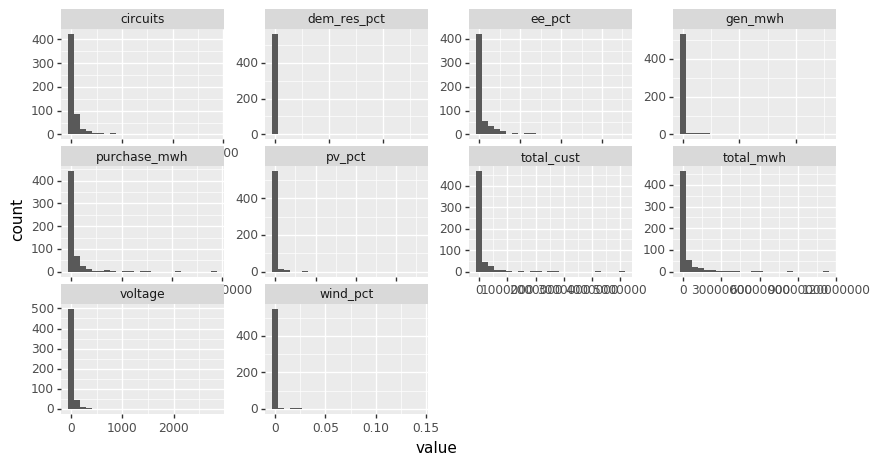

<ggplot: (8765464299017)>

In [476]:
# Plot the continuous variables 
df_num = train_X.select_dtypes(include="number").melt()

(
    ggplot(df_num,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

## Categorical Variables

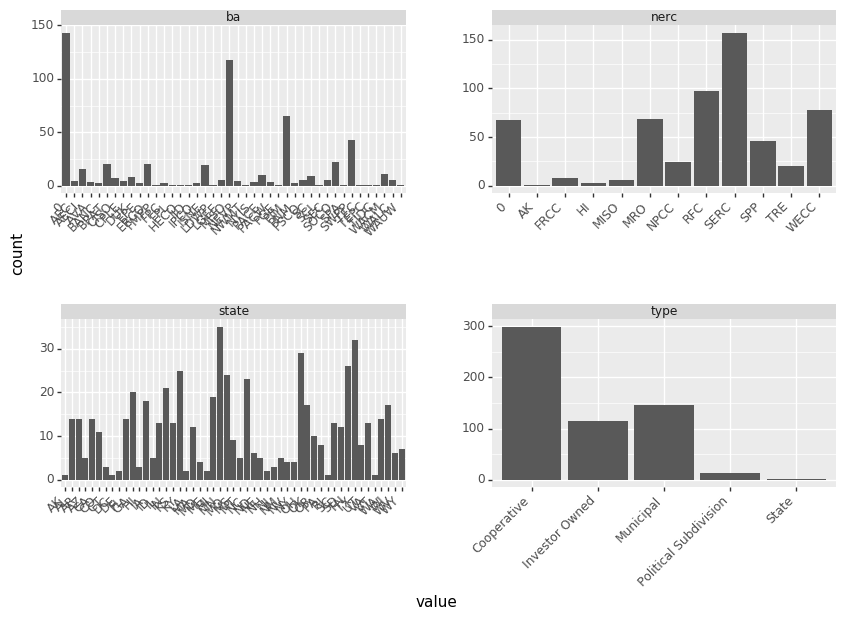

<ggplot: (8765489978709)>

In [458]:
# plot distributions of categorical variables
df_cat = train_X.select_dtypes(include="category").melt()

(
    ggplot(df_cat,aes(x="value")) +
    geom_bar() +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,6),
          subplots_adjust={'wspace':0.25,
                           'hspace':0.75},
         axis_text_x=element_text(rotation=45, hjust=1))
)

### Let's dummify NERC regions, state, and utility type

In [487]:
nerc_dummies = pd.get_dummies(df_19.nerc)

In [488]:
# we'll use None as our reference category
nerc_dummies = nerc_dummies.drop(['0'],axis=1)
nerc_dummies.head()

,AK,ECAR,FRCC,HI,MISO,MRO,NPCC,RFC,SERC,SPP,TRE,WECC
0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


In [489]:
df_19 = pd.concat([df_19.drop(['nerc'],axis=1),nerc_dummies],axis=1)

In [490]:
type_dummies = pd.get_dummies(df_19.type)

In [491]:
# we'll use State as our reference category
type_dummies = type_dummies.drop(['State'],axis=1)
type_dummies.head()

,Cooperative,Investor Owned,Municipal,Political Subdivision
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,0,1,0,0


In [492]:
df_19 = pd.concat([df_19.drop(['type'],axis=1),type_dummies],axis=1)

In [493]:
state_dummies = pd.get_dummies(df_19.state)

In [494]:
# we'll use AK as our reference category
state_dummies = state_dummies.drop(['AK'],axis=1)
state_dummies.head()

,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [495]:
df_19 = pd.concat([df_19.drop(['state'],axis=1),state_dummies],axis=1)

### Check newly dummifed categorical variables (continuous now)

In [503]:
y = df_19['saidi_nomed']
X = df_19.drop(columns=['no','name','total_cust','ba',
                       'saidi_nomed','saifi_nomed', 'caidi_nomed',
                       'gen_mwh', 'purchase_mwh', 
                       'pv_mwh', 'wind_mwh', 'nm_mwh', 'ee_mwh',
                       'dem_res_customers', 'dem_res_mwh',
                        'nm_pct'])

In [505]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1997)

## Statsmodels linear regression test

In [378]:
import statsmodels.formula.api as smf

In [380]:
df_19.columns

Index(['name', 'state', 'total_mwh', 'total_cust', 'no', 'type', 'saidi_nomed',
       'saifi_nomed', 'caidi_nomed', 'circuits', 'voltage', 'ba', 'pv_mwh',
       'wind_mwh', 'nm_mwh', 'ee_mwh', 'dem_res_customers', 'dem_res_mwh',
       'pv_pct', 'wind_pct', 'nm_pct', 'ee_pct', 'dem_res_pct',
       'dem_res_cust_pct'],
      dtype='object')

In [387]:
results = smf.ols('saidi_nomed ~ circuits + voltage + total_mwh + dem_res_cust_pct + C(ba) + C(type) + C(state)', data=df_19).fit()
#print(results.summary())

# Attempt 1.5

## Log method

In [508]:
df_19

,name,total_mwh,total_cust,no,saidi_nomed,saifi_nomed,caidi_nomed,circuits,voltage,gen_mwh,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,Adams Electric Coop,176102.0,8931.0,97.0,169.740,1.29,131.5814,47.0,47.0,4612.0,...,0,0,0,0,0,0,0,0,0,0
1,Adams-Columbia Electric Coop,515186.0,37607.0,108.0,139.900,0.95,147.26316,95.0,16.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,Agralite Electric Coop,238558.0,5251.0,155.0,128.759,1.181,109.0254,64.0,0.0,447.0,...,0,0,0,0,0,0,0,0,0,0
3,Aiken Electric Coop Inc,938436.0,48059.0,162.0,97.720,.,.,122.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,Alaska Electric Light&Power Co,337796.0,17280.0,213.0,79.000,2.08,37.980769,31.0,31.0,123203.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,Ameren Illinois Company,8017902.0,499059.0,56697.0,132.290,0.995,132.95477,2966.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
763,Liberty Utilities,564462.0,48770.0,57483.0,416.510,2.96,140.71284,42.0,0.0,131026.0,...,0,0,0,0,0,0,0,0,0,0
764,PUD No 1 of Jefferson County,376212.0,19742.0,59013.0,291.000,2.04,142.64706,21.0,21.0,0.0,...,0,0,0,0,0,0,1,0,0,0
765,Upper Michigan Energy Resources Corp.,1610240.0,36818.0,60631.0,238.000,1.5,158.66667,57.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [518]:
df_19_log = df_19.copy()

# Version 1 just log everything
df_19_log['total_mwh'] = np.log(df_19['total_mwh'])
df_19_log['circuits'] = np.log(df_19['circuits'])
df_19_log['voltage'] = np.log(df_19['voltage'] + 1)

df_19_log['pv_pct'] = np.log(df_19['pv_pct'] + 1)
df_19_log['wind_pct'] = np.log(df_19['wind_pct'] + 1)
df_19_log['ee_pct'] = np.log(df_19['ee_pct'] + 1)
df_19_log['dem_res_pct'] = np.log(df_19['dem_res_pct'] + 1)

In [519]:
y = df_19_log['saidi_nomed']
X = df_19_log.drop(columns=['no','name','total_cust','ba',
                       'saidi_nomed','saifi_nomed', 'caidi_nomed',
                       'gen_mwh', 'purchase_mwh', 
                       'pv_mwh', 'wind_mwh', 'nm_mwh', 'ee_mwh',
                       'dem_res_customers', 'dem_res_mwh',
                        'nm_pct'])
train_X_log, test_X_log, train_y_log, test_y_log = train_test_split(X,y,test_size=.25,random_state=1997)

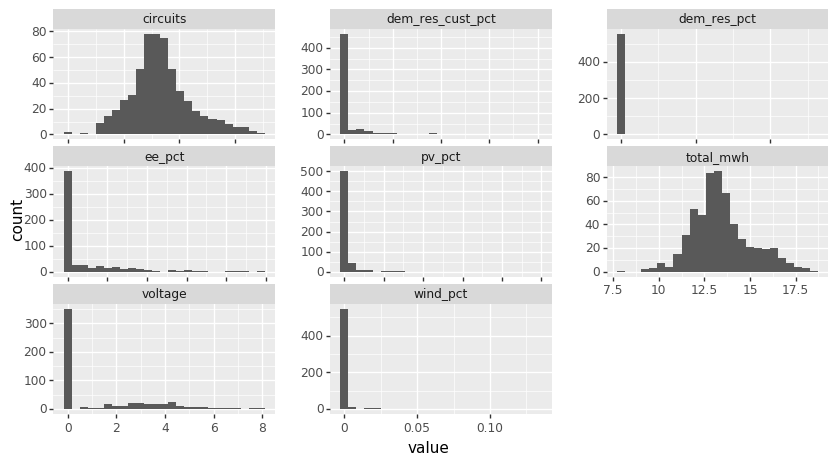

<ggplot: (8765466748769)>

In [535]:
d = train_X_log.iloc[:,:8]

(
    ggplot(d.melt(),aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

### Median Method

In [540]:
# all columns before the dummies
train_X.iloc[:,:8].columns

Index(['total_mwh', 'circuits', 'voltage', 'pv_pct', 'wind_pct', 'ee_pct',
       'dem_res_pct', 'dem_res_cust_pct'],
      dtype='object')

In [541]:
# Version 2 use the medians and log total_mwh and circuits because that works
df_19_med = df_19.copy() 

# total_mwh and circuits logged
df_19_med['total_mwh'] = np.log(df_19['total_mwh'])
df_19_med['circuits'] = np.log(df_19['circuits'])


# voltage pct
median_voltage_pct = df_19.loc[df_19_med['voltage'] > 0,'voltage'].median()
df_19_med['voltage'] =  np.where(df_19_med['voltage']==0,0,np.where(df_19_med['voltage'] <= median_voltage_pct,1,2))

# pv pct
median_pv_pct = df_19.loc[df_19_med['pv_pct'] > 0,'pv_pct'].median()
df_19_med['pv_pct'] =  np.where(df_19_med['pv_pct']==0,0,np.where(df_19_med['pv_pct'] <= median_pv_pct,1,2))

# wind pct
median_wind_pct = df_19_med.loc[df_19_med['wind_pct'] > 0,'wind_pct'].median()
df_19_med['wind_pct'] =  np.where(df_19_med['wind_pct']==0,0,np.where(df_19_med['wind_pct'] <= median_wind_pct,1,2))

# energy efficiency pct
median_ee_pct = df_19_med.loc[df_19_med['ee_pct'] > 0,'ee_pct'].median()
df_19_med['ee_pct'] =  np.where(df_19_med['ee_pct']==0,0,np.where(df_19_med['ee_pct'] <= median_ee_pct,1,2))

# demand response pct
median_dr_pct = df_19_med.loc[df_19_med['dem_res_pct'] > 0,'dem_res_pct'].median()
df_19_med['dem_res_pct'] =  np.where(df_19_med['dem_res_pct']==0,0,np.where(df_19_med['dem_res_pct'] <= median_dr_pct,1,2))

# demand response customer pct
median_drc_pct = df_19_med.loc[df_19_med['dem_res_cust_pct'] > 0,'dem_res_cust_pct'].median()
df_19_med['dem_res_cust_pct'] =  np.where(df_19_med['dem_res_cust_pct']==0,0,np.where(df_19_med['dem_res_cust_pct'] <= median_drc_pct,1,2))

In [544]:
y = df_19_med['saidi_nomed']
X = df_19_med.drop(columns=['no','name','total_cust','ba',
                       'saidi_nomed','saifi_nomed', 'caidi_nomed',
                       'gen_mwh', 'purchase_mwh', 
                       'pv_mwh', 'wind_mwh', 'nm_mwh', 'ee_mwh',
                       'dem_res_customers', 'dem_res_mwh',
                        'nm_pct'])
train_X_med, test_X_med, train_y_med, test_y_med = train_test_split(X,y,test_size=.25,random_state=1997)

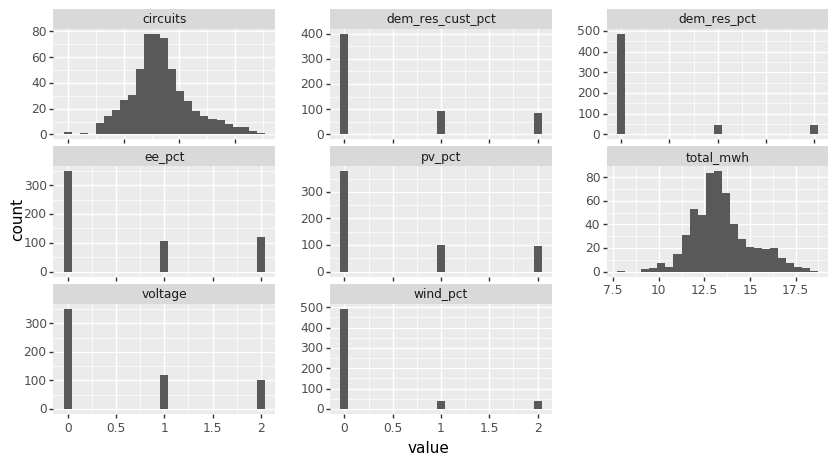

<ggplot: (8765466444185)>

In [547]:
d = train_X_med.iloc[:,:8]

(
    ggplot(d.melt(),aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

## Sqrt Method

In [214]:
# Version 4 use sqrt transform 
df_19_sqrt = df_19.copy()

df_19_sqrt['pv_pct'] = np.sqrt(df_19_sqrt['pv_pct'])
df_19_sqrt['wind_pct'] = np.sqrt(df_19_sqrt['wind_pct'])
df_19_sqrt['ee_pct'] = np.sqrt(df_19_sqrt['ee_pct'])
df_19_sqrt['dem_res_pct'] = np.sqrt(df_19_sqrt['dem_res_pct'])

In [215]:
y = df_19_sqrt['saidi_nomed']
X = df_19_sqrt[['total_cust','pv_pct','wind_pct','ee_pct','dem_res_pct']]
train_X_sqrt, test_X_sqrt, train_y_sqrt, test_y_sqrt = train_test_split(X,y,test_size=.25,random_state=1997)

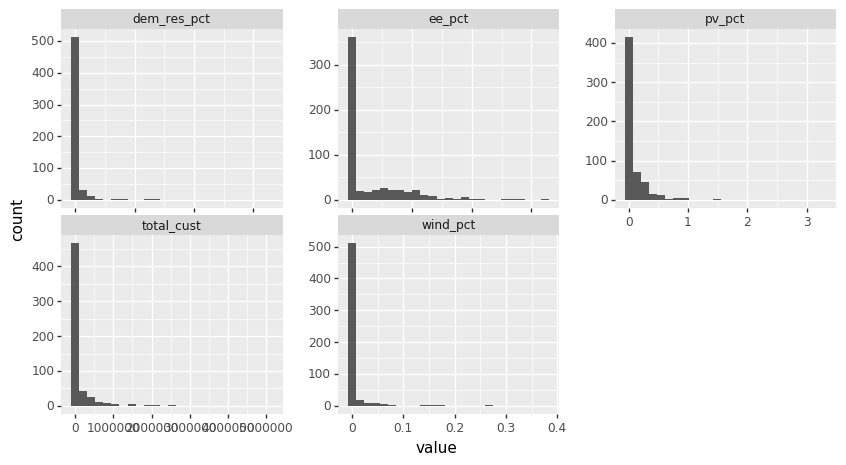

<ggplot: (8765490032401)>

In [217]:
(
    ggplot(train_X_sqrt.melt(),aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

In [220]:
from scipy import stats

In [225]:
# Version 5 use box-cox
df_19_box = df_19.copy()

df_19_box['pv_pct'] = stats.boxcox(df_19_box['pv_pct'] + 1)[0]
df_19_box['wind_pct'] = stats.boxcox(df_19_box['wind_pct'] + 1)[0]
df_19_box['ee_pct'] = stats.boxcox(df_19_box['ee_pct']+ 1)[0]
df_19_box['dem_res_pct'] = stats.boxcox(df_19_box['dem_res_pct'] + 1)[0]

In [226]:
y = df_19_box['saidi_nomed']
X = df_19_box[['total_cust','pv_pct','wind_pct','ee_pct','dem_res_pct']]
train_X_box, test_X_box, train_y_box, test_y_box = train_test_split(X,y,test_size=.25,random_state=1997)

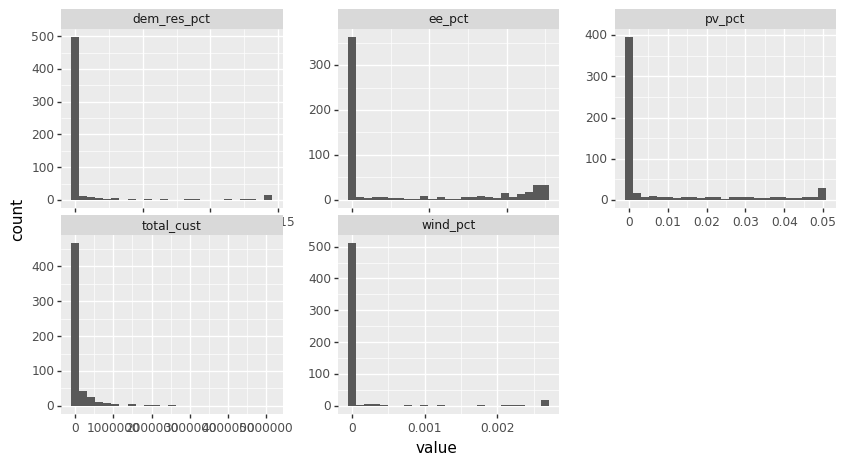

<ggplot: (8765492334813)>

In [227]:
(
    ggplot(train_X_box.melt(),aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

# Compare skews

In [550]:
pd.DataFrame({
'OG': train_X.skew(),
'log':train_X_log.skew(),
'med':train_X_med.skew()
#'sqrt':train_X_sqrt.skew(),
#'box-cox':train_X_box.skew()
})

,OG,log,med
total_mwh,6.667333,0.477582,0.477582
circuits,5.584260,0.517052,0.517052
voltage,7.975704,1.173707,0.924391
pv_pct,18.323248,8.764684,1.083670
wind_pct,9.511568,9.271155,2.503223
...,...,...,...
VT,23.979158,23.979158,23.979158
WA,6.188382,6.188382,6.188382
WI,5.569176,5.569176,5.569176
WV,9.660773,9.660773,9.660773


#### Best for each:

- total_mwh and circuits: Log (makes the most sense and roughly normal distribution)
- everything else: Med

## Manual Machine Learning

### Preprocess

In [285]:
# Let's put everything on a scale between 1 and 0 
scaler = pp.MinMaxScaler()
col_names = list(train_X_med) # save the column names because the scaler makes it into a numpy array
train_X = scaler.fit_transform(train_X_med)

In [286]:
# Convert back into data frame with the column names
train_X_med = pd.DataFrame(train_X_med,columns=col_names)

In [287]:
train_X_med.describe()

,pv_pct,wind_pct,ee_pct,dem_res_pct
count,575.000000,575.000000,575.000000,575.000000
mean,0.516522,0.158261,0.740870,0.186087
std,0.769172,0.401648,0.941114,0.463077
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,2.000000,0.000000
max,2.000000,2.000000,2.000000,2.000000


In [288]:
train_y_med.describe()

count     575.000000
mean      141.710558
std       146.387884
min         1.394000
25%        55.045500
50%        99.800000
75%       175.702000
max      1239.300000
Name: saidi_nomed, dtype: float64

### Modeling

In [553]:
# EVERYTHING must hold constant other than the algorithm because we're looking for the best algorithm 
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111) # make sure splits are same with random state

In [554]:
type(fold_generator)

sklearn.model_selection._split.KFold

In [555]:
# just MSE but negative, used by sklearn
use_metrics = ["neg_mean_squared_error"] 

### Linear Model

In [556]:
lm_scores = cross_validate(LM(),train_X_med,train_y_med, cv = fold_generator, scoring =use_metrics)

In [557]:
from sklearn.linear_model import LinearRegression

In [558]:
mod = LinearRegression()

In [559]:
mod.fit(train_X_med, train_y_med)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [560]:
mod.coef_

array([-3.65019767e+01,  2.96211942e+01,  1.81238153e+00,  6.11080707e+00,
        2.59654262e+01, -3.97535696e+00,  1.64606168e+01, -4.63162702e+00,
        7.22017579e+14,  8.81129015e+15, -3.72485502e+01,  6.28936479e+14,
        6.94596611e+01,  7.65019275e+01, -2.55922078e+01, -8.08640115e+01,
        6.38860394e+01,  1.88809151e+02, -1.37120806e+02, -2.24616389e+02,
        6.41119893e+01,  2.25389299e+01, -7.56842836e+01,  2.13045124e+02,
        7.22017579e+14,  7.22017579e+14,  7.22017579e+14,  7.22017579e+14,
        7.22017579e+14,  7.22017579e+14,  7.22017579e+14,  7.22017579e+14,
        7.22017579e+14,  7.22017579e+14,  9.30810999e+13,  7.22017579e+14,
        7.22017579e+14,  7.22017579e+14,  7.22017579e+14,  7.22017579e+14,
        7.22017579e+14,  7.22017579e+14,  7.22017579e+14,  7.22017579e+14,
        7.22017579e+14,  7.22017579e+14,  7.22017579e+14,  7.22017579e+14,
        7.22017579e+14,  7.22017579e+14,  7.22017579e+14,  7.22017579e+14,
        7.22017579e+14,  

### KNN

In [561]:
knn_scores = cross_validate(KNN(),train_X_med,train_y_med, cv = fold_generator, scoring =use_metrics)

In [562]:
KNN().get_params

<bound method BaseEstimator.get_params of KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')>

### Decision Tree

In [563]:
dt_scores = cross_validate(DTree(),train_X_med,train_y_med, cv = fold_generator, scoring =use_metrics)

#### Side Note: Plotting a Decision Tree
First, a quick side note on the decision trees. When we built a tree from scratch, we discussed looking at the **decision rules** of the tree. There is a very straight forward way of doing this in `sklearn`.

In [582]:
# grab the column names
col_names = train_X_med.columns

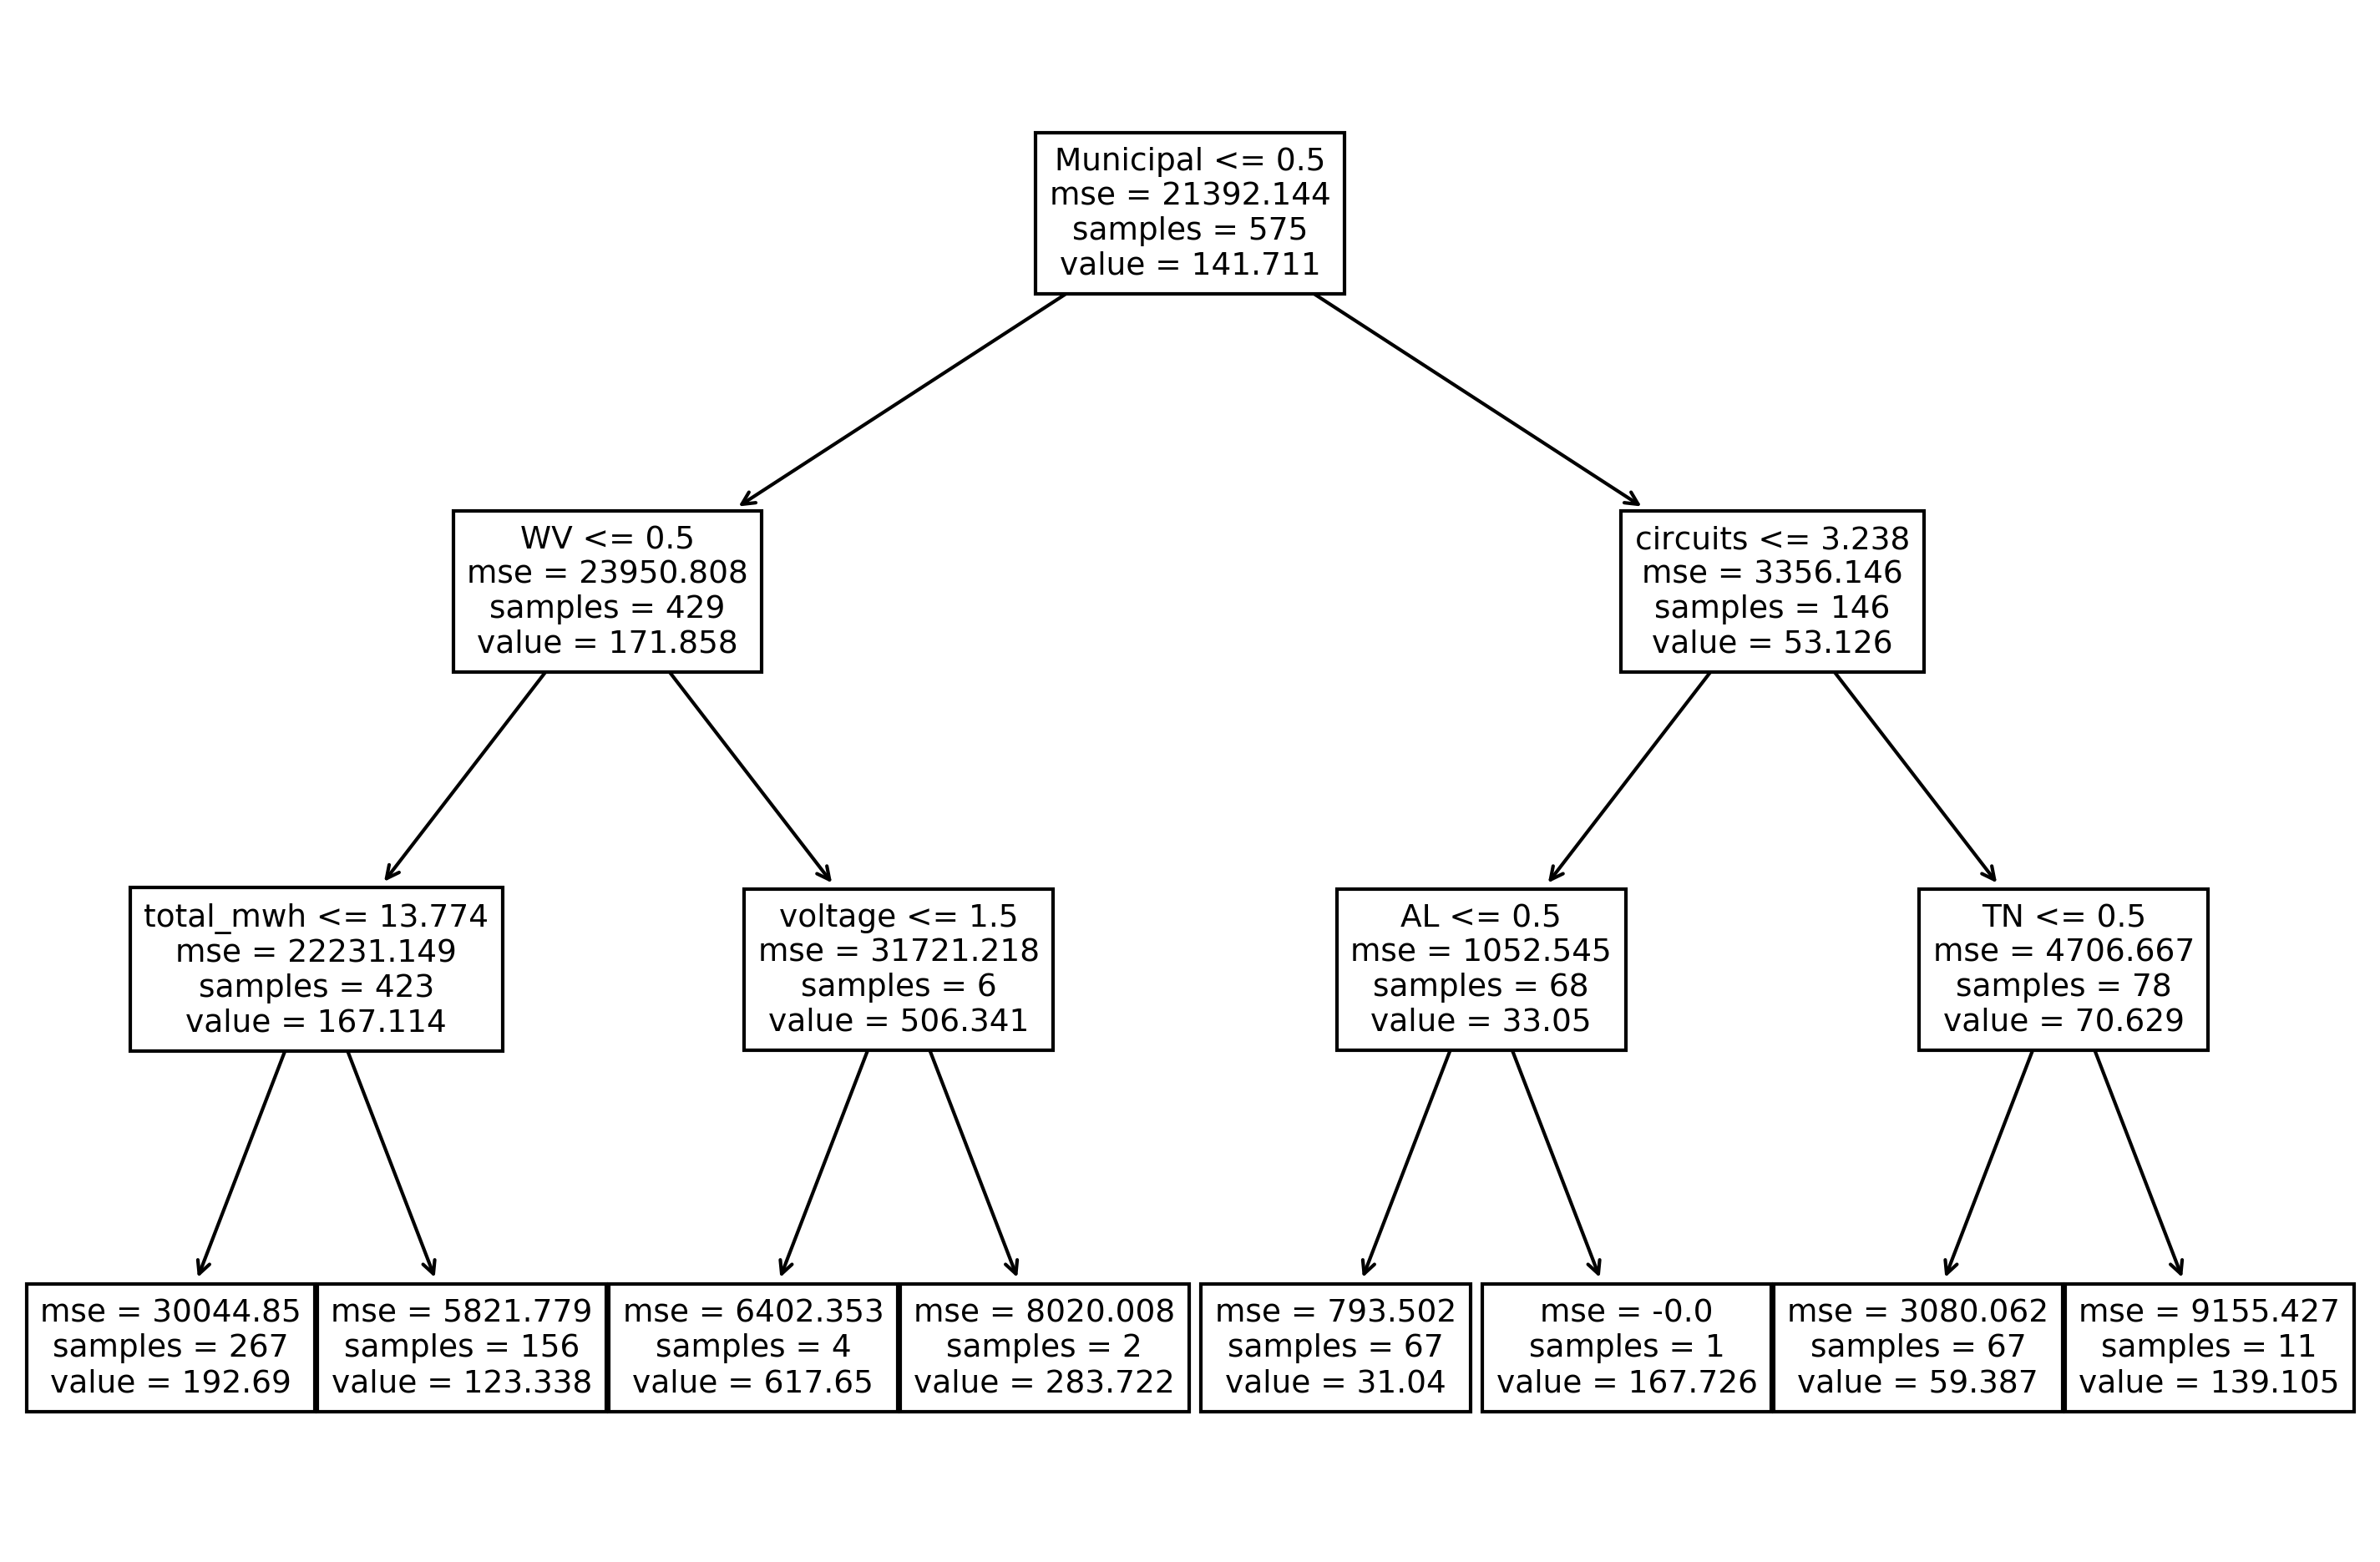

In [583]:
mod = DTree(max_depth=3) # Initialize the modeling object (just as we did)
mod.fit(train_X_med,train_y_med) # Fit the model

# Plot the tree
plt.figure(figsize=(12,8),dpi=300)
rules = tree.plot_tree(mod,feature_names = col_names,fontsize=9)

### Bagging

In [565]:
bag_scores = cross_validate(Bag(),train_X,train_y, cv = fold_generator, scoring =use_metrics)

### Random Forest

In [566]:
# takes longer, because 1000 models 
rf_scores = cross_validate(RF(),train_X_med,train_y_med, cv = fold_generator, scoring =use_metrics)

In [567]:
RF().get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)>

## Compare models

In [571]:
# Collect all the metrics we care about as a dictionary 
# name them by which method we used
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

# Convert to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name="Model",value_name="MSE")
collect_scores

,Model,MSE
0,lm,1.076125e+26
1,lm,3.371013e+27
2,lm,1.120779e+29
3,lm,1.340202e+27
4,lm,9.140168e+26
5,knn,2.502539e+04
6,knn,2.792638e+04
7,knn,1.385562e+04
8,knn,2.035200e+04
9,knn,1.259813e+04


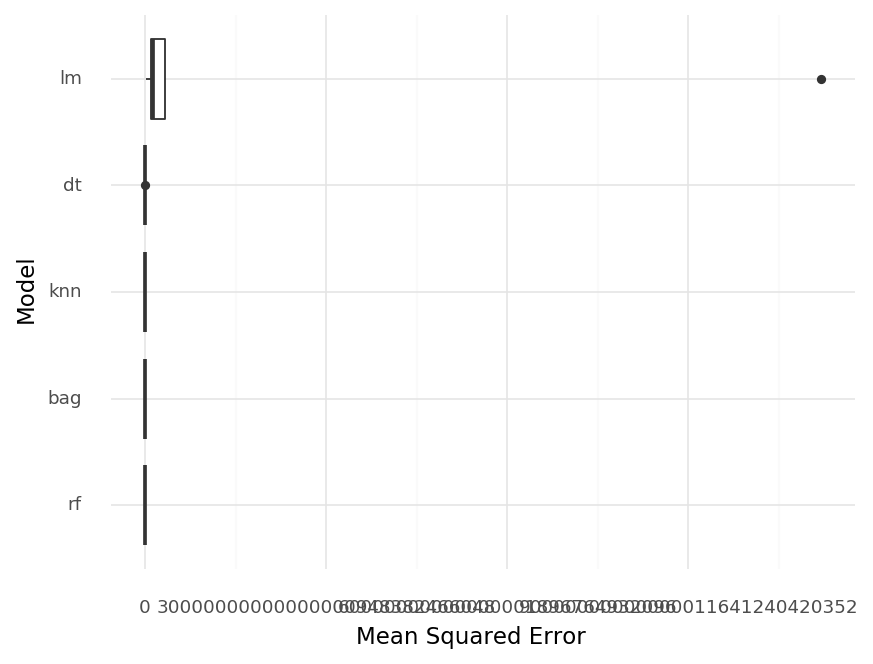

<ggplot: (8765469821945)>

In [572]:
# Get the order of the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

# Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

In [573]:
search.fit(train_X_med,train_y_med)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1971s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1513s.) Setting batch_size=4.
[Parallel(n_jobs=4)]: Done  48 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Batch computation too slow (2.2823s.) Setting batch_size=1.
[Parallel(n_jobs=4)]: Done 132 tasks      | elapsed:   30.3s
[Parallel(n_jobs=4)]: Done 157 tasks      | elapsed:   45.2s
[Parallel(n_jobs=4)]: Done 170 tasks      | elapsed:   57.7s
[Parallel(n_jobs=4)]: Done 185 tasks      | elapsed:  1.2min
[Paralle

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pre_process',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         MinMaxScaler(copy=True,
                                                                                      feature_range=(0,
                                                                                                     1)),
                                                                         <sklearn.compose._column_trans

In [574]:
search.best_score_ # Mean out-of-sample (CV) error

-17860.72307881594

In [575]:
search.best_params_

{'model': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False),
 'model__max_depth': 3,
 'model__n_estimators': 500}

In [579]:
pred_y_med = search.predict(test_X_med)

In [580]:
m.mean_squared_error(test_y_med,pred_y_med)


13630.812030619903

In [581]:
m.r2_score(test_y_med,pred_y_med)


0.11501697379712472

In [586]:
# Our RMSE is about the same as one standard deviation
test_y_med.describe()

count    192.000000
mean     129.998693
std      124.430637
min        0.655000
25%       58.015000
50%       99.240000
75%      159.112500
max      909.710000
Name: saidi_nomed, dtype: float64

# Build machine learning pipeline

In [314]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)

In [315]:
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(),  make_column_selector(dtype_exclude=None))])

In [316]:
# initialize our pipeline 
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

In [317]:
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param, use double underscore to separate model from its parameter__
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]

In [318]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4,
                      verbose = 10)

# Attempt 1

## Log Method Results

In [ ]:
# log method
search.fit(train_X,train_y)

In [112]:
search.best_score_ # Mean out-of-sample (CV) error

-21082.61436550224

In [113]:
search.best_params_

{'model': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1250, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False),
 'model__max_depth': 3,
 'model__n_estimators': 1250}

In [114]:
pred_y = search.predict(test_X)

In [115]:
m.mean_squared_error(test_y,pred_y)


15986.957948610108

In [116]:
m.r2_score(test_y,pred_y)


-0.037956241591254214

## Median Method

In [ ]:
search.fit(train_X,train_y)

In [123]:
search.best_score_ # Mean out-of-sample (CV) error

-21120.39481983883

In [124]:
pred_y = search.predict(test_X)

In [125]:
m.mean_squared_error(test_y,pred_y)

16057.475013154188

In [126]:
m.r2_score(test_y,pred_y)


-0.04253457522530124

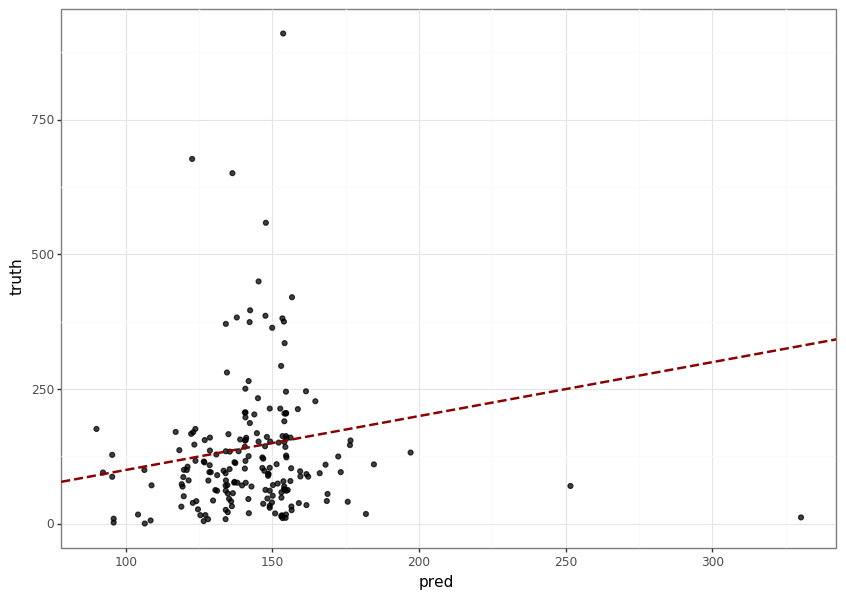

<ggplot: (8765491538285)>

In [117]:
# see how in the pipeline we preprocessed X so it is fixed beforehand and we can make sense of the predictions 
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

## Retry while doing preprocessing scaler overtly

In [154]:
y = df_19['saidi_nomed']
X = df_19[['total_cust','nm_pct','ee_pct','dem_res_pct']]

In [155]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1997)

In [144]:
print(train_X.shape[0]/df_19.shape[0])
print(test_X.shape[0]/df_19.shape[0])

0.7496740547588006
0.2503259452411995


In [152]:
# Plot the continuous variables 
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,5),
          subplots_adjust={'wspace':0.25})
)

AttributeError: 'numpy.ndarray' object has no attribute 'melt'

In [141]:
# Version 3 just log everything
df_19['total_cust'] = np.log(df_19['total_cust'])
df_19['nm_pct'] = np.log(df_19['nm_pct'] + 1)
df_19['ee_pct'] = np.log(df_19['ee_pct'] + 1)
df_19['dem_res_pct'] = np.log(df_19['dem_res_pct'] + 1)

In [157]:
scaler = pp.StandardScaler()

In [158]:
scaler = scaler.fit(train_X)


In [160]:
X_scaled = scaler.transform(train_X)


In [162]:
X_scaled.mean(axis=0)

array([ 2.47145299e-16, -1.39019231e-17, -1.85358975e-17,  9.26794873e-18])

## Unresolved

## Discard

In [449]:
# rename column heading
# nerc_dummies.rename(columns={"0": "None"})